### Word Embeddings
Following the [DeepLearning.AI course on Sequence Models](https://www.coursera.org/learn/nlp-sequence-models).

Word embeddings are representations of words in a vector space. Each dimension represents a feature (e.g., "blue" and "red" are close on the color dimension). In this case, we are using the pre-trained GloVe embeddings, which has 50 dimensions.

In [1]:
import numpy as np

def read_glove_vecs():
    with open('datasets/glove_6B_50d.txt', 'r', encoding='utf-8') as f:
        words = set()
        word2vec = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word2vec[curr_word] = np.array(line[1:], dtype=np.float64)
    return words, word2vec

words, word2vec = read_glove_vecs()

In [2]:
print(word2vec['banana'])
print(word2vec['banana'].shape)

[-0.25522  -0.75249  -0.86655   1.1197    0.12887   1.0121   -0.57249
 -0.36224   0.44341  -0.12211   0.073524  0.21387   0.96744  -0.068611
  0.51452  -0.053425 -0.21966   0.23012   1.043    -0.77016  -0.16753
 -1.0952    0.24837   0.20019  -0.40866  -0.48037   0.10674   0.5316
  1.111    -0.19322   1.4768   -0.51783  -0.79569   1.7971   -0.33392
 -0.14545  -1.5454    0.0135    0.10684  -0.30722  -0.54572   0.38938
  0.24659  -0.85166   0.54966   0.82679  -0.68081  -0.77864  -0.028242
 -0.82872 ]
(50,)


Given that embeddings are vectors, we can calculate the similarity between two words using the cosine similarity:

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

In [3]:
def cosine_similarity(u, v):
    return u @ v  / (np.linalg.norm(u) * np.linalg.norm(v))

where:
- cos(0) = 1 (they are the same word)
- cos(90) = 0 (orthogonal, so no similarity)
- cos(180) = -1 (similarity, but in the opposite direction)

In [4]:
print("similarity(banana, fruit):", cosine_similarity(word2vec['banana'], word2vec['fruit']))
print("similarity(banana, fire):", cosine_similarity(word2vec['banana'], word2vec['fire']))

similarity(banana, fruit): 0.7181406064676134
similarity(banana, fire): 0.15051801204391835


One of the most interesting properties of the word embeddings is that we can perform arithmetic.

king - man + woman = queen

<img src="https://blog.acolyer.org/wp-content/uploads/2016/04/word2vec-king-queen-composition.png" width="300"/>

In [5]:
u = word2vec['king'] - word2vec['man'] + word2vec['woman']
max_sim = -100
best_word = None
for w in words:
    if w in ['king', 'man', 'woman']:
        continue
    sim = cosine_similarity(u, word2vec[w])
    if sim > max_sim:
        max_sim = sim
        best_word = w
print("king - man + woman =", best_word)

king - man + woman = queen


Function to solve the general case with words a b c:

In [6]:
def complete_analogy(word_a, word_b, word_c):
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    e_a, e_b, e_c = word2vec[word_a], word2vec[word_b], word2vec[word_c]
    
    words = word2vec.keys()
    max_cosine_sim = -100
    best_word = None
    
    for w in words:
        if w == word_c:
            continue
        
        cosine_sim = cosine_similarity((e_b - e_a), (word2vec[w] - e_c))
        
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
            
    return best_word

In [7]:
triads_to_try = [
    ('king', 'man', 'queen'),
    ('france', 'paris', 'japan'),
    ('japan', 'japanese', 'china')]
for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format(*triad, complete_analogy(*triad)))

king -> man :: queen -> woman
france -> paris :: japan -> tokyo
japan -> japanese :: china -> chinese


We can visualize the embeddings in 2D by using t-SNE for dimensionality reduction and K-means for clustering.

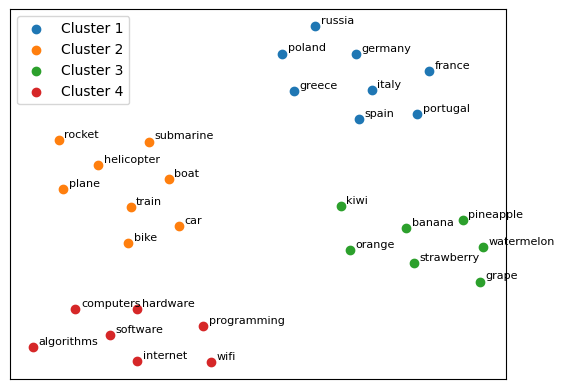

In [30]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tech = ['internet', 'computers', 'wifi', 'software', 'hardware', 'programming', 'algorithms']
fruits = ['banana', 'pineapple', 'orange', 'grape', 'strawberry', 'kiwi', 'watermelon']
countries = ['france', 'germany', 'spain', 'portugal', 'italy', 'greece', 'poland', 'russia']
vehicles = ['car', 'bike', 'train', 'plane', 'boat', 'submarine', 'helicopter', 'rocket']
special_words =  tech + fruits + countries + vehicles
num_clusters = 4

vectors = np.array([word2vec[w] for w in special_words])

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(vectors)

tsne = TSNE(n_components=2, perplexity=12, random_state=0)
vectors_tsne = tsne.fit_transform(vectors)

for i in range(num_clusters):
    plt.scatter(vectors_tsne[clusters == i, 0], vectors_tsne[clusters == i, 1], label=f"Cluster {i+1}")

for word, (x, y) in zip(special_words, vectors_tsne):
    plt.annotate(word, xy=(x, y), xytext=(4, 2), textcoords='offset points', fontsize=8)
    
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()